# MNIST handwritten digits recognition

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import struct

## Data loading

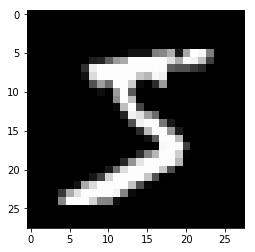

In [12]:
%matplotlib inline
with open('data/train-images-idx3-ubyte','rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    nrows, ncols = struct.unpack(">II", f.read(8))
    x_train_raw = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
    x_train_raw = x_train_raw.reshape((size, nrows, ncols))
    
plt.imshow(x_train_raw[0,:,:], cmap='gray')
plt.show()

In [13]:
with open('data/train-labels-idx1-ubyte','rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    y_train_raw = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
    
y_train_raw[0]

5

In [14]:
from sklearn.preprocessing import OneHotEncoder
y_train = OneHotEncoder(categories='auto', sparse=False).fit_transform(y_train_raw.reshape(-1, 1))
y_train = np.expand_dims(y_train, axis=1)
print(y_train[0])

[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]


## Model building

In [15]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder
import time

In [16]:
mnist_model = MLPClassifier(
    hidden_layer_sizes=(300,),
    activation='relu',
    solver='adam',
    shuffle=True,
    verbose=False,
    early_stopping=True,
    n_iter_no_change=20,
    max_iter=200,
    random_state=1234
)

In [17]:
with open('data/t10k-images-idx3-ubyte','rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    nrows, ncols = struct.unpack(">II", f.read(8))
    x_test_raw = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
    x_test_raw = x_test_raw.reshape((size, nrows, ncols))
    
with open('data/t10k-labels-idx1-ubyte','rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    y_test_raw = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
    
y_test = OneHotEncoder(categories='auto', sparse=False).fit_transform(y_test_raw.reshape(-1, 1))    

def score(model, X):
    predictions = model.predict_proba(X)
    res = np.argmax(predictions, axis=1).flatten()
    err = (1 - np.equal(res, y_test_raw).sum() / res.size) * 100
    print("Error: {0:.2f}%".format(err))

In [18]:
X = x_train_raw.reshape((x_train_raw.shape[0],-1))
y = OneHotEncoder(categories='auto', sparse=False).fit_transform(y_train_raw.reshape(-1, 1))

start = time.time()
mnist_model.fit(X, y)
elapsed = time.time() - start
print("Time elapsed: {0:.0f} sec.".format(elapsed))

X_test = x_test_raw.reshape((x_test_raw.shape[0], -1))
score(mnist_model, X_test)

Time elapsed: 241 sec.
Error: 2.23%


## Data exploration

First, let's try to frame an image. It can help us speed up fitting process.

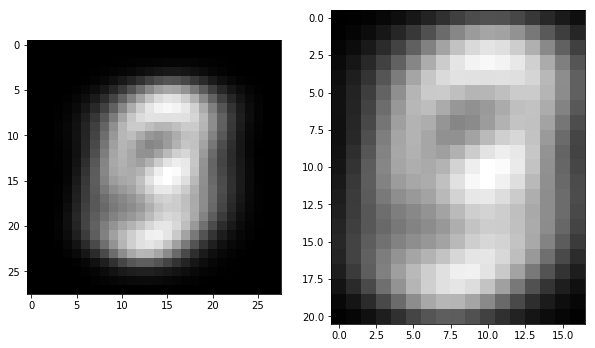

In [19]:
mean_input = np.mean(x_train_raw, axis=0)
plt.rcParams["figure.figsize"] = (10, 7)
plt.subplot(121)
plt.imshow(mean_input, cmap='gray')
plt.subplot(122)
plt.imshow(mean_input[4:25, 5:22], cmap='gray')
plt.show()

In [20]:
X = x_train_raw[:, 4:25, 5:22].reshape((x_train_raw.shape[0],-1))
y = OneHotEncoder(categories='auto', sparse=False).fit_transform(y_train_raw.reshape(-1, 1))

start = time.time()
mnist_model.fit(X, y)
elapsed = time.time() - start
print("Time elapsed: {0:.0f} sec.".format(elapsed))

X_test = x_test_raw[:, 4:25, 5:22].reshape((x_test_raw.shape[0], -1))
score(mnist_model, X_test)

Time elapsed: 86 sec.
Error: 2.21%


More than 3 times faster and precision even improved!

Now, let's try to deskew images.

In [21]:
from scipy.ndimage import interpolation


def moments(image):
    c0,c1 = np.mgrid[:image.shape[0],:image.shape[1]] # A trick in numPy to create a mesh grid
    totalImage = np.sum(image) #sum of pixels
    m0 = np.sum(c0*image)/totalImage #mu_x
    m1 = np.sum(c1*image)/totalImage #mu_y
    m00 = np.sum((c0-m0)**2*image)/totalImage #var(x)
    m11 = np.sum((c1-m1)**2*image)/totalImage #var(y)
    m01 = np.sum((c0-m0)*(c1-m1)*image)/totalImage #covariance(x,y)
    mu_vector = np.array([m0,m1]) # Notice that these are \mu_x, \mu_y respectively
    covariance_matrix = np.array([[m00,m01],[m01,m11]]) # Do you see a similarity between the covariance matrix
    return mu_vector, covariance_matrix

def deskew(image):
    c,v = moments(image)
    alpha = v[0,1]/v[0,0]
    affine = np.array([[1,0],[alpha,1]])
    ocenter = np.array(image.shape)/2.0
    offset = c-np.dot(affine,ocenter)
    img = interpolation.affine_transform(image,affine,offset=offset)
    return (img - img.min()) / (img.max() - img.min())

def input_preprocessing(X):
    out = np.empty((X.shape[0], 21, 17))
    for i in range(X.shape[0]):
        out[i] = deskew(X[i, 4:25, 5:22])
    return out


X = input_preprocessing(x_train_raw).reshape((x_train_raw.shape[0],-1))
y = OneHotEncoder(categories='auto', sparse=False).fit_transform(y_train_raw.reshape(-1, 1))

start = time.time()
mnist_model.fit(X, y)
elapsed = time.time() - start
print("Time elapsed: {0:.0f} sec.".format(elapsed))

X_test = input_preprocessing(x_test_raw).reshape((x_test_raw.shape[0], -1))
score(mnist_model, X_test)

Time elapsed: 48 sec.
Error: 1.18%


Almost two times faster and much more precise.

## Kaggle competition

In [29]:
kaggle_set = np.loadtxt('data/kaggle/test.csv', skiprows=1, delimiter=',')
kaggle_raw = kaggle_set.reshape(28000, 28, 28)
kaggle = input_preprocessing(kaggle_raw).reshape((kaggle_raw.shape[0], -1))

In [35]:
import pandas as pd


answer = np.argmax(mnist_model.predict_proba(kaggle), axis=1).flatten()
output = pd.DataFrame({'Label':answer})
output.index.rename('ImageId', inplace=True)
output.reset_index(inplace=True)
output['ImageId'] += 1
output.to_csv('submission.csv', index=False)
output.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3
